In [30]:
import pymongo
from pymongo import MongoClient
from bson.son import SON
from bson.objectid import ObjectId
import rdflib
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
client = MongoClient()
db = client.lobbyradar

Entities = db.entities
Relations = db.relations

person_filter = { 'type' : 'person' }
entity_filter = { 'type' : 'entity' }
persons = Entities.find(person_filter)
entities = Entities.find(entity_filter)

In [3]:
# executive, ececutive, Vorsitzender
directors_board_members = ['Aufsichtsratsmitglied', 'Board of Directors', 'Mitglied des Aufsichtsrats', 'Mitglied im Aufsichtsrat', 'Lenkungsgruppe', 'Mitglied des Aufsichtsrates', 'Anteilseignervertreter', 'Stellvertretender Vorstandsvorsitzender des Aufsichtsrats']
management_board_members = ['Vorstandsmitglied', 'Mitglied des Vorstands']
presidial_board_members = ['Präsidialmitglied', 'Mitglied des Präsidiums', 'Präsidiumsmitglied']
chairmen_of_management = ['Vorstandsvorsitz', 'Vorstandsvorsitzender', 'Vorsitzender des Vorstands']
management_members = ['Vorstand']
chairmen_of_directors_board = ['Aufsichtsratsvorsitz', 'Vorsitzender des Aufsichtsrats']
foundation_board_members = ['Mitglied des Stiftungsrats', 'Stiftungsrat']
directors = ['Geschäftsführer', 'Hauptgeschäftsführer', 'CEO', 'Geschäftsführender Vorstand', 'Geschäftsführender Gesellschafter', 'Direktor']
presidents = ['Präsident', 'Vorsitz', 'Vorsitzender', 'Präsidentin']
trustees_board_members = ['Mitglied des Kuratoriums']
advidory_board_members = ['Mitglied im Beirat', 'Mitglied des Beirats', 'Beisitzer des Beirats']
vice_presidents = ['Stellvertretender Vorsitz', 'Vize-Präsident', 'Vizepräsident']
administration_board_members = ['Mitglied des Verwaltungsrats']

In [4]:
# member, activity, position
ordinary_members = ['Ordentliches Mitglied']
representative_members = ['Stellvertretendes Mitglied']
chairmen = ['Obmann']
chairwomen = ['Obfrau']
alliance_members = ['Mitglied im Verband']
honorary_members = ['Ehrenmitglied']

In [5]:
# government, Bundesdatenschutzbeauftragte
ministers = ['Staatsminister', 'Staatsministerin', 'Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit', 'Bundesministerin für Familie, Senioren, Frauen und Jugend', 'Bundesminister für Wirtschaft und Technologie', 'Minister für Inneres und Kommunales', 'Minister für Inneres und Sport', 'Bundesminister für Ernährung, Landwirtschaft und Verbraucherschutz', 'Bundesministerin für Bildung, Wissenschaft, Forschung und Technologie', 'Bundesminister für besondere Aufgaben', 'Bundesminister für Arbeit und Soziales', 'Bundesminister des Auswärtigen', 'Bundesminister des Inneren', 'Minister für Umwelt und Verbraucherschutz', 'Bundesminister für Verbraucherschutz', 'Ernährung und Landwirtschaft', 'Minister der Justiz und für Verbraucherschutz', 'Bundesminister für Verkehr, Bau und Stadtentwicklung', 'Staatsrätin für Bundesangelegenheiten, Europa und Integration', 'Ministerin für Arbeit, Gleichstellung und Soziales', 'Minister für Energie, Infrastruktur und Landesentwicklung', 'Ministerin für Kultus', 'Ministerin für Schule und Berufsbildung', 'Senator für Inneres und Sport', 'Ministerin für Bildung, Wissenschaft, Weiterbildung und Kultur', 'Minister für Wirtschaft, Arbeit und Verkehr', 'Ministerin für Arbeit, Soziales, Gesundheit, Frauen und Familie']
secretaries_of_states = ['Staatssekretär', 'Parlamentarischer Staatssekretär', 'Parlamentarische Staatssekretärin', 'Staatssekretärin']
privy_counselors = ['Staatsrat', 'Staatsrätin']
prime_ministers = ['Ministerpräsident', 'Ministerpräsidentin']
heads_of_state_chancellery = ['Chef der Staatskanzlei']
representatives_of_federal_chancellor = ['Stellvertreter der Bundeskanzlerin']
ministers_of_defense = ['Bundesminister der Verteidigung']
representatives_of_prime_minister = ['Stellvertretender Ministerpräsident', 'Stellvertreter des Ministerpräsidenten', 'Stellvertretende Ministerpräsidentin']
finance_ministers = ['Bundesminister der Finanzen', 'Finanzminister', 'Minister der Finanzen ']
justice_ministers = ['Minister der Justiz', 'Bundesministerin der Justiz', 'Justizministerin']

In [6]:
import rdflib
from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
from rdflib.namespace import DC, FOAF, SKOS
ORG = Namespace("http://www.w3.org/ns/org#")
OWN = Namespace("http://example.org/")

# The Graph
g = Graph()
g.bind("dc", DC)
g.bind("foaf", FOAF)
g.bind("org", ORG)
g.bind("skos", SKOS)
g.bind("own", OWN)

g.parse('ontology.ttl', format='turtle')

for entity in Entities.find({}):
    node = BNode()
    # DC
    g.add((node, DC.identifier, Literal(entity["_id"])))
    g.add((node, DC.created, Literal(entity["created"])))
    g.add((node, DC.modified, Literal(entity["updated"])))
    
    # RDF
    if entity['type'] == 'person':
        g.add((node, RDF.type, FOAF.Person))
        g.add((node, FOAF.name, Literal(entity["name"])))

    elif entity['type'] == 'entity':
        g.add((node, RDF.type, ORG.Organization))
        g.add((node, SKOS.prefLabel, Literal(entity["name"])))
        for alias in entity["aliases"]:
            g.add((node, SKOS.altLabel, Literal(alias)))
            
    # FOAF
    for tag in entity['tags']:
        g.add((node, FOAF.topic_intest, Literal(tag)))

In [7]:
# Add executive relations
for rel in Relations.find({ 'type' : { '$in' : ['executive', 'ececutive', 'Vorsitzender'] }}):
    pos = [ attr['value'] for attr in rel['data'] if attr['key'] == 'position' ]
    pos = pos[0].encode('utf-8') if pos else ''.encode('utf-8')
    dest_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][0])))
    target_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][1])))
    
    if dest_node and target_node:
        # dest and target must be here
        dest_type = g.value(subject=dest_node, predicate=RDF.type)
        target_type = g.value(subject=target_node, predicate=RDF.type)
        
        if dest_type != target_type:
            # dest and target can not have the same tye
            if (dest_type == ORG.Organization) and (target_type == FOAF.Person):
                # the subject must be the person
                dest_node, target_node = target_node, dest_node

            if pos in directors_board_members:
                g.add((dest_node, OWN.isDirectorsBoardMemberOf, target_node))
            elif pos in management_board_members:
                g.add((dest_node, OWN.isManagementBoardMemberOf, target_node))
            elif pos in presidial_board_members:
                g.add((dest_node, OWN.isPresidialBoardMemberOf, target_node))
            elif pos in chairmen_of_management:
                g.add((dest_node, OWN.isChairmenOfManagement, target_node))
            elif pos in management_members:
                g.add((dest_node, OWN.isManagementMember, target_node))
            elif pos in chairmen_of_directors_board:
                g.add((dest_node, OWN.isChairmanOfDirectorsBoardOf, target_node))
            elif pos in foundation_board_members:
                g.add((dest_node, OWN.isFoundationBoardMemberOf, target_node))
            elif pos in directors:
                g.add((dest_node, OWN.isDirectorOf, target_node))
            elif pos in presidents:
                g.add((dest_node, OWN.isPresidentOf, target_node))
            elif pos in trustees_board_members:
                g.add((dest_node, OWN.isTrusteesBoardMemberOf, target_node))
            elif pos in advidory_board_members:
                g.add((dest_node, OWN.isAdvisoryBoardMemberOf, target_node))
            elif pos in vice_presidents:
                g.add((dest_node, OWN.isVicePresidentOf, target_node))
            elif pos in administration_board_members:
                g.add((dest_node, OWN.isAdministrationBoardMemberOf, target_node))
            else:
                g.add((dest_node, OWN.isOtherExecutiveOf, target_node))

In [8]:
# Add member relations
for rel in Relations.find({ 'type' : { '$in' : ['member', 'activity', 'position'] }}):
    pos = [ attr['value'] for attr in rel['data'] if attr['key'] == 'position' ]
    pos = pos[0].encode('utf-8') if pos else ''.encode('utf-8')
    if len(rel['entities']) == 2:
        dest_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][0])))
        target_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][1])))

        if dest_node and target_node:
            # dest and target must be here
            dest_type = g.value(subject=dest_node, predicate=RDF.type)
            target_type = g.value(subject=target_node, predicate=RDF.type)

            if dest_type != target_type:
                # dest and target can not have the same tye
                if (dest_type == ORG.Organization) and (target_type == FOAF.Person):
                    # the subject must be the person
                    dest_node, target_node = target_node, dest_node

                if pos in ordinary_members:
                    g.add((dest_node, OWN.isOrdinaryMemberOf, target_node))
                elif pos in representative_members:
                    g.add((dest_node, OWN.isRepresentativeMemberOf, target_node))
                elif pos in chairmen:
                    g.add((dest_node, OWN.isChairmanOf, target_node))
                elif pos in chairwomen:
                    g.add((dest_node, OWN.isChairwomanOf, target_node))
                elif pos in alliance_members:
                    g.add((dest_node, OWN.isAllianceMemberOf, target_node))
                elif pos in honorary_members:
                    g.add((dest_node, OWN.isHonoraryMemberOf, target_node))
                else:
                    g.add((dest_node, OWN.isOtherMemberOf, target_node))

In [9]:
# Add government relations
for rel in Relations.find({ 'type' : { '$in' : ['government', 'Bundesdatenschutzbeauftragte'] }}):
    pos = [ attr['value'] for attr in rel['data'] if attr['key'] == 'position' ]
    pos = pos[0].encode('utf-8') if pos else ''.encode('utf-8')
    if len(rel['entities']) == 2:
        dest_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][0])))
        target_node = g.value(predicate=DC.identifier, object=Literal(str(rel['entities'][1])))
    
    if dest_node and target_node:
            # dest and target must be here
            dest_type = g.value(subject=dest_node, predicate=RDF.type)
            target_type = g.value(subject=target_node, predicate=RDF.type)

            if dest_type != target_type:
                # dest and target can not have the same tye
                if (dest_type == ORG.Organization) and (target_type == FOAF.Person):
                    # the subject must be the person
                    dest_node, target_node = target_node, dest_node
                # target organisation must be a governmental organisation
                g.add((target_node, RDF.type, OWN.Government)) 
                
                if pos in secretaries_of_states:
                    g.add((dest_node, OWN.isSecretaryOfStateOf, target_node))   
                elif pos in privy_counselors:
                    g.add((dest_node, OWN.isPrivyCouncilorOf, target_node))
                elif pos in ministers:
                    g.add((dest_node, OWN.isMinisterOf, target_node))
                elif pos in prime_ministers:
                    g.add((dest_node, OWN.isPrimeMinisterOf, target_node))
                elif pos in heads_of_state_chancellery:
                    g.add((dest_node, OWN.isHeadOfStateChancelleryOf, target_node))
                elif pos in representatives_of_federal_chancellor:
                    g.add((dest_node, OWN.isRepresentativeOfFederalChancellor, target_node))
                elif pos in ministers_of_defense:
                    g.add((dest_node, OWN.isMinisterOfDefenseOf, target_node))
                elif pos in representatives_of_prime_minister:
                    g.add((dest_node, OWN.isRepresentativeOfPrimeMinisterOf, target_node))
                elif pos in finance_ministers:
                    g.add((dest_node, OWN.isFinanceMinisterOf, target_node))
                elif pos in justice_ministers:
                    g.add((dest_node, OWN.isJusticeMinisterOf, target_node))
                else :
                    g.add((dest_node, OWN.isOtherwiseRelatedToGovernment, target_node))

In [10]:
def search_persons(name = ""):
    qres = g.query(""" 
    SELECT DISTINCT ?name
    WHERE { 
          ?person rdf:type foaf:Person .
          ?person foaf:name ?name .
          FILTER(regex(lcase(str(?name)), \"""" + name.lower() + """\", "i"))
    }
    LIMIT 100
    """)
    return [ name[0].toPython() for name in qres ]

In [11]:
def search_sparql(query):
    return g.query(query)

In [12]:
def search_governmental(name = ""):
    qres = g.query(""" 
    SELECT DISTINCT ?name
    WHERE { 
          ?org rdf:type own:Government .
          ?org skos:prefLabel ?name .
          FILTER(regex(lcase(str(?name)), \"""" + name.lower() + """\", "i")) .
    }
    LIMIT 100
    """)
    return [ name[0].toPython() for name in qres ]

In [13]:
def search_organizations(name = ""):
    qres = g.query(""" 
    SELECT DISTINCT ?name
    WHERE { 
          ?org rdf:type org:Organization .
          ?org skos:prefLabel ?name .
          FILTER(regex(lcase(str(?name)), \"""" + name.lower() + """\", "i")) .
    }
    LIMIT 100
    """)
    return [ name[0].toPython() for name in qres ]

In [16]:
def person_connections(name):
    qres = g.query("""
    SELECT DISTINCT ?aname ?property ?bname
    WHERE {
        {
            ?p rdfs:isSubPropertyOf own:isMemberOf .
            ?property rdfs:isSubPropertyOf ?p .
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname . 
        }
        UNION
        { 
            ?property rdfs:isSubPropertyOf own:isMemberOf . 
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname .
        }
        FILTER(lcase(str(?aname)) = \"""" + name.lower() + """\") .
    } 
    LIMIT 100""")
    return [ (row[0].toPython(), row[1].toPython(), row[2].toPython()) for row in qres ]

In [150]:
def organization_connections(name):
    qres = g.query("""
    SELECT DISTINCT ?aname ?property ?bname
    WHERE {
        {
            ?p rdfs:isSubPropertyOf own:isMemberOf .
            ?property rdfs:isSubPropertyOf ?p .
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname . 
        }
        UNION
        { 
            ?property rdfs:isSubPropertyOf own:isMemberOf . 
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname .
        }
        FILTER(lcase(str(?bname)) = \"""" + name.lower() + """\") .
    } 
    LIMIT 100""")
    return [ (row[0].toPython(), row[1].toPython(), row[2].toPython()) for row in qres ]

In [136]:
G = nx.Graph()
nx.draw_networkx_labels?

In [148]:
def plot_tripples(connections_triple, figsize=(20,10)):
    G = nx.Graph()
    for obj, prt, sub in connections_triple:
        G.add_node(obj, typ='obj')
        G.add_node(sub, typ='sub')
        G.add_edge(obj, sub, label=prt)
    colors = [ 'green' if G.node[node]['typ'] == 'obj' else 'red' for node in G.nodes() ]
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.family'] = 'sans-serif'
    nx.draw_networkx(G, node_color=colors, node_size=1000, linewidths=0, font_size=16)

In [154]:
#conn_triples = person_connections("Angela merkel")
search_organizations("Bundeskanzleramt")
org_conn_tripple = organization_connections("Bundeskanzleramt")

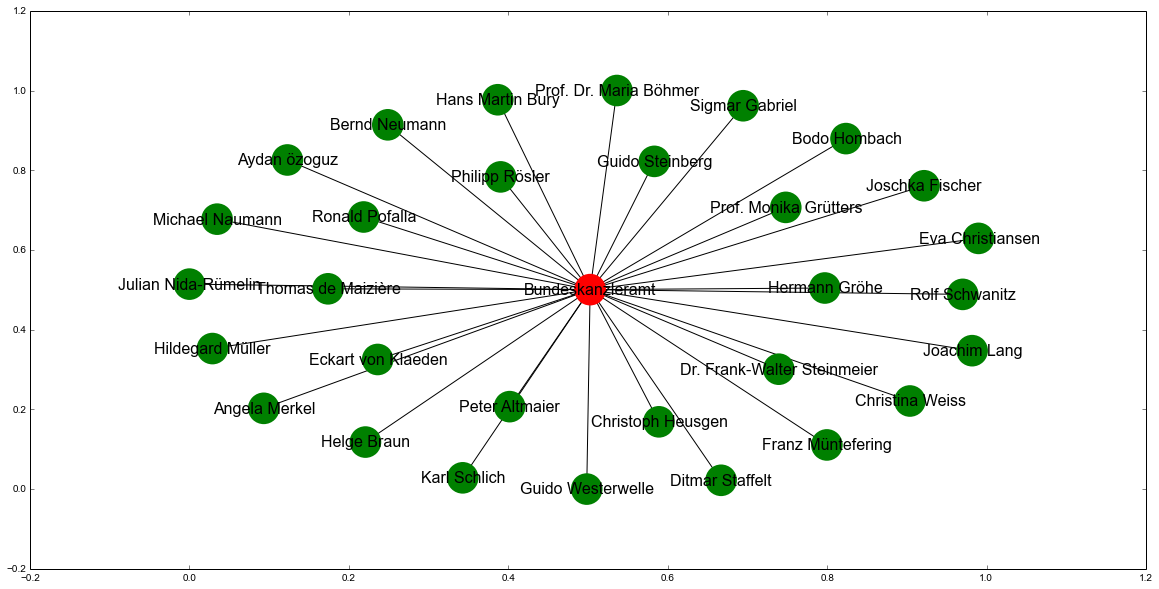

In [155]:
#search_persons("andrea"a)
plot_tripples(org_conn_tripple)

In [17]:
person_connections("Andreas Breitner")

[(u'Andreas Breitner',
  u'http://example.org/isOtherwiseRelatedToGovernment',
  u'Ministerium f\xfcr Inneres und Bundesangelegenheiten Schleswig-Holstein'),
 (u'Andreas Breitner', u'http://example.org/isOtherMemberOf', u'SPD'),
 (u'Andreas Breitner',
  u'http://example.org/isOtherMemberOf',
  u'Landesministerium f\xfcr Inneres und Bundesangelegenheiten (Schleswig-Holstein)'),
 (u'Andreas Breitner',
  u'http://example.org/isOtherMemberOf',
  u'Verband Norddeutscher Wohnungsunternehmen')]

In [120]:
# ... add some triples to g somehow ...
qres = g.query(""" 
SELECT DISTINCT ?aname ?property ?bname
    WHERE {
        ?property rdfs:isSubPropertyOf own:isMemberOf .
        ?a ?property ?b .
        ?a foaf:name ?aname .
        ?b skos:prefLabel ?bname .
    }
    LIMIT 100""")

for row in qres:
    print("%s %s %s" % row)

Andreas G. Lämmel http://example.org/isOrdinaryMemberOf Ausschuss für Wirtschaft und Energie
Florian Oßner http://example.org/isOrdinaryMemberOf Ausschuss für Verkehr und digitale Infrastruktur
Jörg Hellmuth http://example.org/isOrdinaryMemberOf Innenausschuss
Stefan Zierke http://example.org/isOrdinaryMemberOf Ausschuss für Tourismus
Britta Haßelmann http://example.org/isOrdinaryMemberOf Der Ältestenrat
Irene Mihalic http://example.org/isOrdinaryMemberOf Edathy-Untersuchungsausschuss
Heinz Riesenhuber http://example.org/isOrdinaryMemberOf Ausschuss für Wirtschaft und Energie
Erika Steinbach http://example.org/isOrdinaryMemberOf Innenausschuss
Jens Spahn http://example.org/isOrdinaryMemberOf Ausschuss für Gesundheit
Alexandra Dinges-Dierig http://example.org/isOrdinaryMemberOf Ausschuss für Bildung, Forschung und Technikfolgenabschätzung
Klaus-Peter Schulze http://example.org/isOrdinaryMemberOf Ausschuss für Tourismus
Heinrich Zertik http://example.org/isOrdinaryMemberOf Ausschuss für 

In [178]:
# ... add some triples to g somehow ...
qres = g.query(""" 
SELECT DISTINCT ?aname ?property ?bname
    WHERE {
        {
            ?p rdfs:isSubPropertyOf own:isMemberOf .
            ?property rdfs:isSubPropertyOf ?p .
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname . 
        }
        UNION
        { 
            ?property rdfs:isSubPropertyOf own:isMemberOf . 
            ?a ?property ?b .
            ?a foaf:name ?aname .
            ?b skos:prefLabel ?bname .
        }
        FILTER(lcase(str(?aname)) = "angela merkel") .
    } LIMIT 100""")

for row in qres:
    print("%s %s %s" % row)

Angela Merkel http://example.org/isOtherwiseRelatedToGovernment Bundeskanzleramt
Angela Merkel http://example.org/isOtherMemberOf Kabinett Merkel III
Angela Merkel http://example.org/isOtherMemberOf Deutscher Bundestag
Angela Merkel http://example.org/isOtherMemberOf Bundesakademie für Sicherheitspolitik
Angela Merkel http://example.org/isOtherMemberOf Deutsche Gesellschaft e.V., Verein zur Förderung politischer, kultureller und sozialer Beziehungen in Europa
Angela Merkel http://example.org/isOtherMemberOf Atlantik-Brücke e.V.
Angela Merkel http://example.org/isOtherMemberOf Stiftung Deutsche Sporthilfe
Angela Merkel http://example.org/isOtherMemberOf Kabinett Merkel I
Angela Merkel http://example.org/isOtherMemberOf Deutsches Museum
Angela Merkel http://example.org/isOtherMemberOf Kabinett Merkel II
Angela Merkel http://example.org/isOtherMemberOf CDU/CSU-Fraktion
Angela Merkel http://example.org/isOtherMemberOf Stiftung Frauenkirche Dresden
Angela Merkel http://example.org/isOtherMe

In [38]:
qres.serialize()

'<?xml version="1.0" encoding="utf-8"?>\n<sparql:sparql xmlns:sparql="http://www.w3.org/2005/sparql-results#" xmlns:xml="http://www.w3.org/XML/1998/namespace"><sparql:head><sparql:variable name="property"></sparql:variable></sparql:head><sparql:results></sparql:results></sparql:sparql>'

In [ ]:
# %load 'ontology.ttl'
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .  
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix org: <http://www.w3.org/ns/org#> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix dcam: <http://purl.org/dc/dcam/> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix : <http://example.org/> .

# T-Box:
:Party a rdfs:Class ;
  rdfs:subClassOf org:Organization .
:Politician a rdfs:Class ;
  rdfs:subClassOf foaf:Person .
:Lobbyist a rdfs:Class ;
  rdfs:subClassOf foaf:Person .
:Source a rdfs:Class ;
  rdfs:subClassOf dc:source .
:Address a rdfs:Class ;
  rdfs:subClassOf vcard:ADR .
:Description a rdfs:Class ;
  rdfs:subClassOf dc:description .
:Topic a rdfs:Class ;
  rdfs:subClassOf foaf:topic .
:LegalForm a rdfs:Class .
:From a rdfs:Class ;
  rdfs:subClassOf dc:date .
:To a rdfs:Class ;
  rdfs:subClassOf dc:date .
:Homepage a rdfs:Class ;
  rdfs:subClassOf foaf:homepage .
:Title a rdfs:Class ;
  rdfs:subClassOf dc:title .
:Photo a rdfs:Class ;
  rdfs:subClassOf foaf:Image .
:FederalState a rdf:Class ;
  rdfs:subClassOf vcard:locality .
:BTCertUID a rdf:Class ;
  rdfs:subClassOf foaf:OnlineAccount .
:Constituency a rdf:Class ;
  rdfs:subClassOf vcard:region .
:Government a rdfs:Class ;
  rdfs:subClassOf org:Organization .

# Member -> data.key: position, type: activity, member, position

:isMemberOf a rdf:Property ; # Mitglied, 
  rdfs:domain foaf:Person ;
  rdfs:range :Organization .
:isExecutiveOf rdfs:isSubPropertyOf :isMemberOf .
:isDonor a rdf:Property ; # -> data.key: position, type: donation, sponsoring
  rdfs:domain foaf:Person ;
  rdfs:range :Party .
:isInBusinessWith a rdf:Property ; # -> data.key: position, type: buisiness
  rdfs:domain foaf:Person ;
  rdfs:range :Party .
:isRelatedTo a rdf:Property ; # -> data.key:position, type: association
  rdfs:domain rdfs:Class ;
  rdfs:range rdfs:Class .
:isSubsidiaryOf a rdf:Property ; # -> data.key:position, type: association, subisdiary, Tochterfirma
  rdfs:domain :Party ;
  rdfs:range :Party .
:isRelatedToGovernment a rdf:Property ;
  rdfs:domain foaf:Person ;
  rdfs:range :Government .

# executive, ececutive, Vorsitzender
:isDirectorsBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Aufsichtsratsmitglied, Board of Directors, Mitglied des Aufsichtsrats, Mitglied im Aufsichtsrat, Lenkungsgruppe, Mitglied des Aufsichtsrates, Anteilseignervertreter, Stellvertretender Vorstandsvorsitzender des Aufsichtsrats
:isManagementBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Vorstandsmitglied, Mitglied des Vorstands
:isPresidentalBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Präsidialmitglied, Mitglied des Präsidiums, Präsidiumsmitglied
:isChairmanOfManagementOf rdfs:isSubPropertyOf :isExecutiveOf . # Vorstandsvorsitz, Vorstandsvorsitzender, Vorsitzender des Vorstands
:isManagementMemberOf rdfs:isSubPropertyOf :isExecutiveOf .  # Vorstand
:isChairmanOfDirectorsBoardOf rdfs:isSubPropertyOf :isExecutiveOf . # Aufsichtsratsvorsitz, Vorsitzender des Aufsichtsrats
:isFoundationBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Mitglied des Stiftungsrats, Stiftungsrat
:isDirectorOf rdfs:isSubPropertyOf :isExecutiveOf . # Geschäftsführer, Hauptgeschäftsführer, CEO, Geschäftsführender Vorstand, Geschäftsführender Gesellschafter, Direktor
:isPresidentOf rdfs:isSubPropertyOf :isExecutiveOf . # Präsident, Vorsitz, Vorsitzender, Präsidentin
:isTrusteesBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Mitglied des Kuratoriums
:isAdvisoryBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Mitglied im Beirat, Mitglied des Beirats, Beisitzer des Beirats
:isVicePresidentOf rdfs:isSubPropertyOf :isExecutiveOf . # Stellvertretender Vorsitz, Vize-Präsident, Vizepräsident
:isAdministrationBoardMemberOf rdfs:isSubPropertyOf :isExecutiveOf . # Mitglied des Verwaltungsrats
:isOtherExecutiveOf rdfs:isSubPropertyOf :isExecutiveOf . # ...

# member, activity, position
:isOrdinaryMemberOf rdfs:isSubPropertyOf :isMemberOf . # Ordentliches Mitglied
:isRepresentativeMemberOf rdfs:isSubPropertyOf :isMemberOf . # Stellvertretendes Mitglied
:isChairmanOf rdfs:isSubPropertyOf :isMemberOf . # Obmann
:isChairwomanOf rdfs:isSubPropertyOf :isMemberOf . # Obfrau
:isAllianceMemberOf rdfs:isSubPropertyOf :isMemberOf . # Mitglied im Verband
:isHonoraryMemberOf rdfs:isSubPropertyOf :isMemberOf . # Ehrenmitglied
:isOtherMemberOf rdfs:isSubPropertyOf :isMemberOf . # ...
 
# government, Bundesdatenschutzbeauftragte
:isSecretaryOfStateOf rdfs:isSubPropertyOf :isRelatedToGovernment . #Staatssekretär, Parlamentarischer Staatssekretär, Parlamentarische Staatssekretärin, Staatssekretärin, 
:isPrivyCouncilorOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Staatsrat, Staatsrätin
:isMinisterOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Staatsminister, Staatsministerin, Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit, Bundesministerin für Familie, Senioren, Frauen und Jugend, Bundesminister für Wirtschaft und Technologie, Minister für Inneres und Kommunales, Minister für Inneres und Sport, Bundesminister für Ernährung, Landwirtschaft und Verbraucherschutz, Bundesministerin für Bildung, Wissenschaft, Forschung und Technologie, Bundesminister für besondere Aufgaben, Bundesminister für Arbeit und Soziales, Bundesminister des Auswärtigen, Bundesminister des Inneren, Minister für Umwelt und Verbraucherschutz, Bundesminister für Verbraucherschutz, Ernährung und Landwirtschaft, Minister der Justiz und für Verbraucherschutz, Bundesminister für Verkehr, Bau und Stadtentwicklung, Staatsrätin für Bundesangelegenheiten, Europa und Integration, Ministerin für Arbeit, Gleichstellung und Soziales, Minister für Energie, Infrastruktur und Landesentwicklung, Ministerin für Kultus, Ministerin für Schule und Berufsbildung, Senator für Inneres und Sport, Ministerin für Bildung, Wissenschaft, Weiterbildung und Kultur, Minister für Wirtschaft, Arbeit und Verkehr, Ministerin für Arbeit, Soziales, Gesundheit, Frauen und Familie 
:isPrimeMinisterOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Ministerpräsident, Ministerpräsidentin
:isHeadOfStateChancelleryOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Chef der Staatskanzlei
:isRepresentativeOfFederalChancellor rdfs:isSubPropertyOf :isRelatedToGovernment . # Stellvertreter der Bundeskanzlerin
:isMinisterOfDefenseOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Bundesminister der Verteidigung
:isRepresentativeOfPrimeMinisterOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Stellvertretender Ministerpräsident, Stellvertreter des Ministerpräsidenten, Stellvertretende Ministerpräsidentin
:isFinanceMinisterOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Bundesminister der Finanzen, Finanzminister, Minister der Finanzen 
:isJusticeMinisterOf rdfs:isSubPropertyOf :isRelatedToGovernment . # Minister der Justiz, Bundesministerin der Justiz, Justizministerin
:isOtherwiseRelatedToGovernment rdfs:isSubPropertyOf :isRelatedToGovernment . #


In [ ]:
ids